## COVID testing and mortality data for the world
This notebook considers the relationship between COVID mortality and
testing results for SARS-CoV-2 coronavirus exposure/infection, using
data for the US obtained from the European Centre for Disease Prevention and Control (https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide).

Our main interest here will be to assess whether the reported testing data for active viral infections are sufficient to explain the variation in COVID-related mortality. People who die of COVID may do 1-4 weeks after being infected (in most cases). Therefore, it is reasonable to anticipate that deaths will follow infections, with a time lag of this order.

Testing in the world has been done quite differently. If we were testing a representative subset of the population in different countries or regions every day using an accurate test, it would be reasoanble to anticipate a nearly 1-1 relationship between positive test counts and mortality counts, at a lag as stated above. In reality, testing intensity varies over time and between countires and regions. The people getting tested are not at all representative of the total population, or even of the high-risk population. 

An additional factor is that not everyone who becomes infected with the coronavirus has the same chance of dying. For example, older people, males, and people in poor health are more likely to die. However, we do not have data on either testing or mortality stratified by these factors. This deficiency is expected to seaken the statistical relationship between test results and mortality in our data. 

The analysis below focuses on using Poisson and related forms of GLM regression to understand the relationship between coronavirus testing results and COVID mortality. The analysis illustrates a number of aspeccts of generalized linear modeling that are important in many other settings.

In [71]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os


In [72]:
# Set this to False if you don't have gnuplot on your machine.  You
# can get gnuplot from www.gnuplot.info.

use_termplot = False

if use_termplot:
    import termplotlib as tpl

In [73]:
# Plot graphs here.
pdf = PdfPages("testing_mortality_world.pdf")

In [74]:
# Next we load the COVID data
dx = pd.read_csv("testing_mortality_world.csv")

In [75]:
# A few values are negative when differenced, replace them with zero.
for x in "cases", "deaths", "cumpos0", "cumpos1", "cumpos2", "cumpos3":
    print("Dropping %d cases where %s is negative" %
          ((dx[x] < 0).sum(), x))
    dx[x] = dx[x].clip(0, np.inf)
print("")

Dropping 15 cases where cases is negative
Dropping 7 cases where deaths is negative
Dropping 41 cases where cumpos0 is negative
Dropping 41 cases where cumpos1 is negative
Dropping 31 cases where cumpos2 is negative
Dropping 27 cases where cumpos3 is negative



## Relationship between testing results and mortality


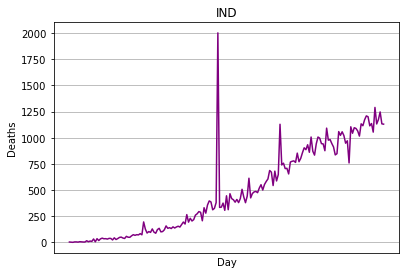

In [76]:
# Below we plot the daily death counts, and the daily counts of
# positive tests for several countries.

fmt = mdates.DateFormatter("%m-%d")
months = mdates.MonthLocator()
# Total tests per day in a country
# dx["dtests"] = dx["dpositive"] + dx["dnegative"]

for ct in "CHN", "USA", "IND":
    for vn in "cases", "deaths":
        ti = {"cases": "Positive tests", "deaths": "Deaths"}[vn]
        
        da = dx.loc[dx.country==ct, :]
        
        # Plot a nice graph and save it as a pdf
        plt.clf()
        plt.axes([0.15, 0.12, 0.8, 0.8])
        plt.grid(True)
        plt.plot(da.date.values.copy(), da[vn].values.copy(), '-', color='purple')
        plt.title(ct)
        plt.xlabel("Day")
        plt.ylabel(ti)
        plt.gca().xaxis.set_major_formatter(fmt)
        plt.gca().xaxis.set_major_locator(months)
        pdf.savefig()



In [77]:
# Transfer the cumulative postive case counts on a log scale
for j in range(4):
    dx["logcumpos%d" % j] = np.log(dx["cumpos%d" % j] + 1)
    
# Get the log population size (for each country).
dx["lpop"] = np.log(dx["popData2019"])

print(dx.size) # observations
print()# country counts
# l_country = dx['country'].unique().tolist()
# d = dict()
# for i in range(len(l_country)):
#     d[i] = l_country[i]
# print(d)
        
# dx.head()

        


838836



Below we will use regression analysis to try to understand how
SARS-CoV-2 testing results relate to COVID mortality.  A reasonable
hypothesis would be that a greater number of positive test results
predicts greater mortality, at a 1-4 week lag.  More specifically,
all else held equal, comparing two places/times where the COVID
prevalence differs by a factor of two over the past month, we expect
there to be a factor of two difference in COVID mortality today.

There are several other factors that we should consider and account
for if possible:

* The virus arrived in different countries at different times, e.g. it
arrived in China before it arrived in the USA.

* Countries vary greatly in terms of population size.  It is possible
that death counts scale with population size (although early in an
epidemic this may not hold).

* Transmission rates may vary by country, e.g. due to population
density.

* The seasons were changing just as the epidemic in the world reached
its peak.  Spring weather may reduce transmission rates.

* The infection/fatality ratio (IFR) may vary by country due to
demographic characteristics of the population and prevalence of
comorbidities.


In [78]:
# Below is an initial regression analysis looking at mortality counts
# per country/day as an outcome, predicted by positive testing results 
# at multiple lags.  We also include country level fixed
# effects to control for the possibility of different ascertainment,
# different infection/fatality ratios, and other forms of
# heterogeneity among the countries.  This initial model is fit using a
# quasi-Poisson generalized linear modeling (GLM) approach.  The model
# includes fixed effects for the countries.

fml = "deaths ~ 0 + C(country) + "
fml += " + ".join(["logcumpos%d" % j for j in range(4)])
m1 = sm.GLM.from_formula(fml, data=dx, family=sm.families.Poisson())
r1 = m1.fit(scale="X2")
print(r1.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                 deaths   No. Observations:                31068
Model:                            GLM   Df Residuals:                    30876
Model Family:                 Poisson   Df Model:                          191
Link Function:                    log   Scale:                          97.550
Method:                          IRLS   Log-Likelihood:                -2748.0
Date:                Fri, 02 Oct 2020   Deviance:                   4.7322e+05
Time:                        11:56:59   Pearson chi2:                 3.01e+06
No. Iterations:                    25                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
C(country)[ABW]        -5.2042    

A perfect 1-1 relationship between testing and mortality would
manifest as a perfect linear relationship between the log number of
cases and the log number of positive tests.  However people who die
of COVID expire at varying times relative to the date of their
positive test. A very simple way to look at the scaling is that if
all four lagging windows of positive tests increased by a given
factor, then the number of deaths today would be expected to
increase by this same factor.  This would imply that the
coefficients for the positive test variables should sum to 1.

An alternative approach to accommodating differences among the
countries is to use generalized estimating equations (GEE), clustering
the data by countries.  This accounts for correlations between the
observations within a country without adding a large number of fixed
effects parameters to the model.  We include here the log of each
country's population to account for the country-to-country differences
that are related to population size.

In [79]:
fml = "deaths ~ lpop  + "
fml += " + ".join(["logcumpos%d" % j for j in range(4)])
m2 = sm.GEE.from_formula(fml, data=dx, groups="country", family=sm.families.Poisson())
r2 = m2.fit(scale="X2")
print(r2.summary())


                               GEE Regression Results                              
Dep. Variable:                      deaths   No. Observations:                31068
Model:                                 GEE   No. clusters:                      188
Method:                        Generalized   Min. cluster size:                  42
                      Estimating Equations   Max. cluster size:                 245
Family:                            Poisson   Mean cluster size:               165.3
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Fri, 02 Oct 2020   Scale:                         192.375
Covariance type:                    robust   Time:                         11:57:00
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.1330      1.057     -4.856      0.000      -7.205      -3.061
lpop   

## Country effects

The analysis above uses country-level fixed effects to account for
country-to-country differences from various sources.  From a statistical
perspective, this is one of several ways to address this issue.
Including large numbers of fixed effects in any regression model can
raise concerns about there being sufficient data to estimate these
parameters.  This is classically known as the "Neyman-Scott"
problem.  Alternatives to fixed effects include mutilevel analysis,
shrunken fixed effects, and marginal analysis that allow for
covariances within countries (which we have done here via GEE).

In [80]:
# Extract the country fixed effects
pa = r1.params
stfe = [[x[9:11], y] for x, y in zip(pa.index, pa.values) if "country" in x]
stfe = pd.DataFrame(stfe, columns=["country", "coef"])
stfe = stfe.sort_values(by="coef")
print("\nCountry fixed effects:\n")
# print(stfe, "\n\n")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(stfe)

        
# Outliners(extreme values): 55ESH-Western Sahara, 12BDI-Burundi, 45CYM-Cayman Islands, 107MCO-Monaco, 44CUW-Curaçao, 117MNP-Northern Mariana Islands, 180VGB-British Virgin Islands, 100LIE-Liechtenstein, 120MSF-Médecins Sans Frontières; 111MEX-Mexico 


Country fixed effects:

    country       coef
55       )[ -24.824731
12       )[ -24.319403
45       )[ -23.638497
107      )[ -23.274447
44       )[ -23.267121
117      )[ -23.103879
180      )[ -23.075599
100      )[ -22.796310
120      )[ -22.308708
150      )[  -7.098715
101      )[  -6.334519
8        )[  -6.148472
85       )[  -5.859086
165      )[  -5.828443
26       )[  -5.678266
28       )[  -5.590283
110      )[  -5.549211
36       )[  -5.432663
143      )[  -5.396047
137      )[  -5.367741
114      )[  -5.347936
157      )[  -5.340584
169      )[  -5.338031
46       )[  -5.334534
40       )[  -5.323549
146      )[  -5.292413
121      )[  -5.235240
70       )[  -5.226375
0        )[  -5.204178
64       )[  -5.094335
90       )[  -5.089701
62       )[  -5.060384
159      )[  -5.020261
67       )[  -5.008569
23       )[  -4.988347
27       )[  -4.877123
18       )[  -4.866241
22       )[  -4.809146
163      )[  -4.800226
181      )[  -4.758787
34       )[  -4.748473
14       

In [81]:
# The country fixed effects discussed above are estimates, not exact
# values.  We can get a sense for how precise the estimates are by
# considering the standard errors. Note that these standard errors may
# be too small, as there is likely to be serial correlation in the
# counts that is not accounted for.  However taken at face-value, the
# standard errors suggest that the state country effects are estimated
# with reasonable accuracy.

ii = [i for i, x in enumerate(pa.index) if "country" in x]
c = r1.cov_params().iloc[ii, ii]
stfe["se"] = np.diag(c)
stfe = stfe.sort_values(by="se")
# print(stfe, "\n\n")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(stfe)
    


    country       coef            se
173      )[  -4.183248  1.877741e-02
35       )[  -3.827948  1.880180e-02
96       )[  -4.204499  1.987262e-02
42       )[  -3.522582  1.994171e-02
182      )[  -3.860370  2.015773e-02
176      )[  -4.291734  2.167306e-02
20       )[  -3.025222  2.195036e-02
165      )[  -5.828443  2.229802e-02
181      )[  -4.758787  2.348913e-02
123      )[  -4.396682  2.375448e-02
90       )[  -5.089701  2.384914e-02
174      )[  -3.891058  2.493942e-02
159      )[  -5.020261  2.517361e-02
112      )[  -2.872803  2.524750e-02
87       )[  -0.912627  2.535858e-02
180      )[ -23.075599  2.618307e-02
73       )[  -4.503385  2.624439e-02
40       )[  -5.323549  2.628639e-02
146      )[  -5.292413  2.676438e-02
164      )[  -3.175551  2.751544e-02
184      )[  -1.646756  2.775161e-02
179      )[  -3.852594  2.781289e-02
33       )[  -2.315233  2.839792e-02
109      )[  -3.871145  2.843477e-02
4        )[  -4.315460  2.938703e-02
128      )[  -1.797105  3.036076e-02
9

Trimming off the tails, the country fixed effect coefficients range
from roughly -7 to -1, a range of around 6.  Since exp(6) is 403,
this suggests that there are pairs of countries that would have around
huge-fold different mortality even under the same amount of positive
test results.

In [82]:
# ## Alternative models and additional sources of confounding

# As with any observational data set, there are many opportunities for
# confounding to mislead us.  One such possibility is that all the
# countries have progressed through the COVID epidemic over roughly the
# same time period, and during this time the weather became much
# warmer in most of the recorded countries. In fact, weather is just one possible
# confounder indexed by time (e.g. standards of care have evolved and
# may have impacted the IFR).  To address this possibility, we fit
# models in which calendar date, or date relative to the country's first
# COVID death are included as controls.  We find that the coefficients
# for the positive testing results are relatively
# invariant to inclusion of these terms.

fml = "deaths ~ 0 + C(country) + bs(rdays, 5) + "
fml += " + ".join(["logcumpos%d" % j for j in range(4)])
m3 = sm.GLM.from_formula(fml, data=dx, family=sm.families.Poisson())
r3 = m3.fit(scale="X2")
# print(r3.summary())


fml = "deaths ~ bs(rdays, 5)  + "
fml += " + ".join(["logcumpos%d" % j for j in range(4)])
m31 = sm.GEE.from_formula(fml, data=dx, groups="country", family=sm.families.Poisson())
r31 = m31.fit(scale="X2")
# print(r31.summary())



fml = "deaths ~ lpop  + bs(rdays, 5) +"
fml += " + ".join(["logcumpos%d" % j for j in range(4)])
m32 = sm.GEE.from_formula(fml, data=dx, groups="country", family=sm.families.Poisson())
r32 = m32.fit(scale="X2")
print(r32.summary())


                               GEE Regression Results                              
Dep. Variable:                      deaths   No. Observations:                31068
Model:                                 GEE   No. clusters:                      188
Method:                        Generalized   Min. cluster size:                  42
                      Estimating Equations   Max. cluster size:                 245
Family:                            Poisson   Mean cluster size:               165.3
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Fri, 02 Oct 2020   Scale:                         121.778
Covariance type:                    robust   Time:                         11:57:14
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -4.5896      0.851     -5.395      0.000      -6.257     

In [83]:
# Above we considered the relationship between infections and mortality
# to be static, i.e. the same relationship exists in all countries at all
# times.  To explore the posibility that this relationship is dynamic,
# meaning that it is different in different places or at different
# times, we can include interactions in the model.

# Here we consider whether the relationship between infections and
# mortality differs between countires with larger and smaller populations.
# Since population size is a country-level variable and we already have
# included country fixed effects in the model, a main effect of
# population size has already been accounted for in the models above.
# However we can take the question of population scaling a bit further
# by considering interactions between population size and the positive
# counts.

dx["lpop_cen"] = dx.lpop - dx.lpop.mean()
fml = "deaths ~ 0 + C(country) + bs(rdays, 5) + "
fml += " + ".join(["lpop_cen:logcumpos%d + logcumpos%d" % (j, j) for j in range(4)])
m4 = sm.GLM.from_formula(fml, data=dx, family=sm.families.Poisson())
r4 = m4.fit(scale="X2")
# print(r4.summary())


# THE MODEL DOES NOT MAKE SENSE BASED ON THE STATISTICS
# fml = "deaths ~ bs(rdays, 5) +"
# fml += " + ".join(["lpop:logcumpos%d + logcumpos%d" % (j, j) for j in range(4)])
# m41 = sm.GEE.from_formula(fml, data=dx, groups="country", family=sm.families.Poisson())
# r41 = m41.fit(scale="X2")
# print(r41.summary())

fml = "deaths ~ 0 + C(country) + bs(rdays, 5) + "
fml += " + ".join(["lpop_cen:logcumpos%d + logcumpos%d + logcumpos%d:rdays" % (j, j, j) for j in range(4)])
m61 = sm.GLM.from_formula(fml, data=dx, family=sm.families.Poisson())
r61 = m61.fit(scale="X2")
print(r61.summary())


fml = "deaths ~ 0 + C(country) + bs(rdays, 5) + "
fml += " + ".join(["lpop_cen:logcumpos%d + logcumpos%d*bs(rdays, 5)" % (j, j) for j in range(4)])
m62 = sm.GLM.from_formula(fml, data=dx, family=sm.families.Poisson())
r62 = m62.fit(scale="X2")
# print(r62.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                 deaths   No. Observations:                31068
Model:                            GLM   Df Residuals:                    30863
Model Family:                 Poisson   Df Model:                          204
Link Function:                    log   Scale:                          38.932
Method:                          IRLS   Log-Likelihood:                -4830.4
Date:                Fri, 02 Oct 2020   Deviance:                   3.1320e+05
Time:                        11:57:36   Pearson chi2:                 1.20e+06
No. Iterations:                    24                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
C(country)[ABW]        -7.6440    

In [84]:
# It is also quite plausible that the relationship between infections
# and mortality has changed over the course of the pandemic.  We can
# consider this possibility by including interactions between the
# testing results and time (rdays).  We first do this by adding a
# "linear by linear" interactions between each positive testing
# variable and the number of days since the first death in a country
# (rdays).

fml = "deaths ~ 0 + C(country) + bs(rdays, 5) + "
fml += " + ".join(["logcumpos%d:rdays + logcumpos%d" % (j, j) for j in range(4)])
m5 = sm.GLM.from_formula(fml, data=dx, family=sm.families.Poisson())
r5 = m5.fit(scale="X2")
print(r5.summary())




                 Generalized Linear Model Regression Results                  
Dep. Variable:                 deaths   No. Observations:                31068
Model:                            GLM   Df Residuals:                    30867
Model Family:                 Poisson   Df Model:                          200
Link Function:                    log   Scale:                          40.492
Method:                          IRLS   Log-Likelihood:                -4657.8
Date:                Fri, 02 Oct 2020   Deviance:                   3.1429e+05
Time:                        11:58:02   Pearson chi2:                 1.25e+06
No. Iterations:                    27                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
C(country)[ABW]        -6.6711    

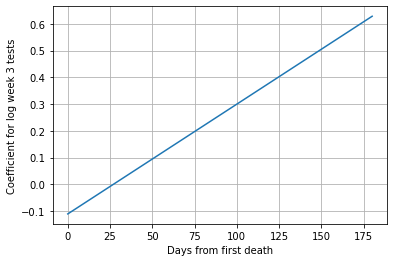

In [85]:
# Below is a plot of the "effective slope" relating mortality to
# logcumpos1 -- logcumpos3.

x = np.linspace(0, 180, 100)
for j in range(4):
    a = r5.params["logcumpos%d" % j]
    b = r5.params["logcumpos%d:rdays" % j]
    y = a + b*x

    if use_termplot:
        fig = tpl.figure()
        fig.plot(x, y, xlabel="Days from first death",
                 title="Coefficient for log week %d tests" % j)
        fig.show()
        print("")

    plt.clf()
    plt.grid(True)
    plt.plot(x.copy(), y.copy(), '-')
    plt.xlabel("Days from first death")
    plt.ylabel("Coefficient for log week %d tests" % j)
    pdf.savefig()

In [86]:
# Now we take this one step further, allowing the effective slope
# of mortality on infections to vary nonlinearly with time.

fml = "deaths ~ 0 + C(country) + bs(rdays, 5) + "
fml += " + ".join(["logcumpos%d*bs(rdays, 5)" % j for j in range(4)])
m6 = sm.GLM.from_formula(fml, data=dx, family=sm.families.Poisson())
r6 = m6.fit(scale="X2")
print(r6.summary())



                 Generalized Linear Model Regression Results                  
Dep. Variable:                 deaths   No. Observations:                31068
Model:                            GLM   Df Residuals:                    30851
Model Family:                 Poisson   Df Model:                          216
Link Function:                    log   Scale:                          34.298
Method:                          IRLS   Log-Likelihood:                -5359.8
Date:                Fri, 02 Oct 2020   Deviance:                   3.0475e+05
Time:                        11:58:18   Pearson chi2:                 1.06e+06
No. Iterations:                    26                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
C(country)[ABW]     

/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

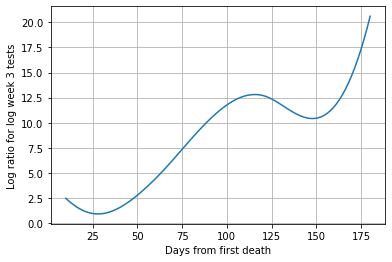

In [87]:
x = np.linspace(0, 180, 100)
for j in range(4):
    a = r5.params["logcumpos%d" % j]
    b = r5.params["logcumpos%d:rdays" % j]
    y = a + b*x

    if use_termplot:
        fig = tpl.figure()
        fig.plot(x, y, xlabel="Days from first death",
                 title="Coefficient for log week %d tests" % j)
        fig.show()
        print("")

    plt.clf()
    plt.grid(True)
    plt.plot(x.copy(), y.copy(), '-')
    plt.xlabel("Days from first death")
    plt.ylabel("Coefficient for log week %d tests" % j)
    pdf.savefig()
# Here is another plot of the "effective slopes" relating mortality to
# logcumpos1 -- logcumpos3, now using the model with nonlinear interactions.
# The key insight here is based on how positive tests at different lags
# predict deaths on a given day, and how these relationships change over
# time.

dxx = dx.iloc[0:200, :].copy()
x = np.linspace(10, 180, 100)
dxx["rdays"] = np.concatenate((x, x))
dxx["country"] = "USA"
dxx[["logcumpos%d" % j for j in range(4)]] = np.log(10000)
for j in range(4):

    dxx["logcumpos%d" % j].iloc[100:] = np.log(20000)

    y = r6.predict(exog=dxx)
    y = y.values.copy()

    if use_termplot:
        fig = tpl.figure()
        fig.plot(x, y[100:200] - y[0:100], xlabel="Days from first death",
                 title="Coefficient for log week %d tests" % j)
        fig.show()
        print("")

    plt.clf()
    plt.grid(True)
    plt.plot(x, y[100:200] - y[0:100], '-')
    plt.xlabel("Days from first death")
    plt.ylabel("Log ratio for log week %d tests" % j)
    pdf.savefig()

    dxx["logcumpos%d" % j].iloc[100:] = np.log(10000)


In [88]:
# We use quasi-AIC (QAIC) instead of AIC for quasi-poisson GLMs.
# Exclude the GEE model here.

m = [m1, m3, m4, m5, m6, m61, m62]
r = [r1, r3, r4, r5, r6, r61, r62]
c = r62.scale # smallest
for j in range(7):
    qaic = -2 * m[j].loglike(r[j].params, scale=1) / c + 2 * m[j].df_resid
    print("Model %d QAIC: %f" % (j+1, qaic))

Model 1 QAIC: 80285.073849
Model 2 QAIC: 76341.105928
Model 3 QAIC: 76137.611300
Model 4 QAIC: 74773.158687
Model 5 QAIC: 74411.273623
Model 6 QAIC: 74727.545558
Model 7 QAIC: 74343.054575


In [89]:
# ## Dispersion and the scale parameter

# Above we focused on the mean structure of the model, which is
# reflected in the slope parameters for the covariates.  These
# parameters determine the expected mortality count for any given
# country/date pair.  We should also consider to what extent the data
# are scattered with respect to this mean.  This is captured through
# the scale parameter of the quasi-Poisson regression.

print("\nScale parameter estimates:")
print(r1.scale)
print(r2.scale)
print(r3.scale)
print(r4.scale)
print(r5.scale)
print(r6.scale)
print(r61.scale)
print(r62.scale, "\n")


Scale parameter estimates:
97.54971997475967
192.37490546209747
74.84532217064384
1518.057070465753
40.49241271912099
34.29810774064414
38.93242219246887
28.928866822975085 



In [90]:
# In an ideal Poisson regression, the scale parameter is equal to 1,
# meaning that the conditional variance is equal to the conditional
# mean.
#
# The conventional approach for estimating the scale parameter is
# analogous to the sample variance, using the "Pearson residuals".

resid = r2.resid_pearson


In [91]:
# This is how the Pearson residuals are constructed:
f = np.exp(np.dot(m2.exog, r2.params))
resid0 = (m2.endog - f) / np.sqrt(f)

# Confirm that the residuals are calculated as expected
assert(np.all(np.abs(resid - resid0) < 1e-10))

# Confirm that the scale parameter estimate is calculated as expected
assert(np.abs(np.sum(resid**2) / (len(resid) - m2.exog.shape[1]) - r2.scale) < 1e-10)

In [92]:
# As we saw above, there are some large outliers in the mortality
# data, and we have good reason to believe that these outliers do not
# reflect actual daily death counts.  Therefore it might make sense to
# use an alternative approach to calculating the scale parameter that
# is not too strongly influenced by a few outlying values.  One way to
# do this is using "Huber's proposal 2" estimate of the scale.  This
# estimator solves a modified ("clipped") version of the moment-based
# estimating equation solved by the usual Pearson estimate of the
# scale parameter.

def g(s, resid):
    c = 1.345
    return np.sum(np.clip(resid / s, -c, c)**2)

In [93]:
# This is around 0.71, slightly less than 1 due
# to clipping.
gam = g(1, np.random.normal(size=50000)) / 50000
print(gam)

0.7119912083061156


In [94]:
# Calculate robust estimates of the scale parameter for each of the
# models discussed above.

def huber_scale(resid, p):

    # This is the equation that we wish to solve to estimate
    # the scale parameter s.
    nobs = len(resid)
    def h(s):
        return g(s, resid).sum() - gam*(nobs - p)

    # Left bracket
    s0 = r.scale
    while h(s0) < 0:
        s0 /= 2

    # Right bracket
    s1 = r.scale
    while h(s1) > 0:
        s1 *= 2

    return root_scalar(h, bracket=[s0, s1]).root**2

from scipy.optimize import root_scalar
scale_huber = []
for (m, r) in (m1, r1), (m2, r2), (m3, r3), (m31, r31), (m32, r32), (m4, r4), (m5, r5), (m6, r6), (m61, r61), (m62, r62):
    s = huber_scale(r.resid_pearson, m1.exog.shape[1])
    scale_huber.append(s)

print("Robust scale parameter estimates:")
for s in scale_huber:
    print("%f" % s)
print("")

Robust scale parameter estimates:
1.610462
3.800005
1.569663
3.060011
3.101466
1.488536
1.376534
1.361972
1.369354
1.351643



In a perfect Poisson situation, the variance would be equal to the
mean.  This perfect Poisson behavior would arise if we had
independence and homogeneity -- independence meaning that any two
people living in the same country on the same day die of COVID
independently of each other, and homogeneity meaning that any two
people living in the same country on the same day have the same
probability of dying of COVID.  Neither condition is likely to hold,
but the homogeneity condition is particularly problematic.  Our data
are not stratified by known risk factors, sex and age being most
well-established.  Pooling data with different event probabilities
will give us a scale parameter greater than 1, as is seen here.

Although we don't have access to the stratified data that we would
need to characterize these sources of dispersion, we can do some
sensitivity analyses to see to what extent age and sex effects might
inflate the scale parameter.


In [95]:
# The following function implements a form of sensitivity analysis in
# which we attempt to identify population structures that are
# consistent with the findings we reached above with the COVID
# tracking project data.  Our goal here is to get a better sense for
# how much heterogeneity would be needed to attain a scale parameter
# around 10, while respecting the marginal mean structure estimated
# above.  We can do this, in a very hypothetical way, by imagining
# that our population consists of two groups with different risks.  If
# we specify the prevalences of these two groups, and the risk ratio
# between them, and force the marginal mean to agree with what we
# found above, we can calculate the scale parameter.
#
# This idea is implemented in the function below.  The parameter
# 'high_risk' is a hypothetical risk ratio between a high risk group
# and a low risk group.  The parameter 'pr_high' is the hypothetical
# proportion of the population in the high risk group.

def scale_2group(high_risk, pr_high):

    # Setting f=high_risk, fraction pr_high of the cases will have
    # mean equal to f*s*ex, where ex is the mean of the observed data.
    # Fraction 1 - pr_high of the cases will have mean equal to s*ex.
    # Thus, the ratio of the mean in the first group to the mean in
    # the second group is f=high_risk.  To match the marginal mean of
    # the data, we need to solve p*f*s + (1-p)*s = 1.

    # The first group has mean f[0]*ex, the second group has mean
    # f[1]*ex.
    f = np.r_[1, high_risk]

    # The first group has frequency pr[0], the second group has
    # frequency pr[1]
    pr = np.r_[1 - pr_high, pr_high]

    # Adjust f so that f[1]/f[0] = high_risk, and the marginal mean
    # matches the fitted mean from the data.
    f /= np.dot(f, pr)

    # Get the means for the two hypothetical groups.
    ex = r1.fittedvalues
    exq = [fx*ex for fx in f]

    # Get the marginal variance if we are sampling from the mixed
    # populations of the two groups.
    mcv = sum([p*b for (p, b) in zip(pr, exq)])
    vcm = sum([p*(b-ex)**2 for (p, b) in zip(pr, exq)])
    tv = mcv + vcm

    # Return the scale parameter that would be seen if working with
    # pooled data from these two subpopulations.

    return (tv / ex).mean()


In [96]:
# We can now calculate the hypothetical scale parameter for an
# imaginary population in which 50% of the population (i.e. males) is
# 4 times more likely to die than the other people (females), we get a
# scale parameter that is similar to the observed scale parameter.
# This suggests that the scale parameters that we are obtaining can be
# explained by the heterogeneity driven by established risk factors
# such as age and sex.

print("Scale parameter due to 4-fold greater risk in half of the population:")
print(scale_2group(4.0, 0.5), "\n")

Scale parameter due to 4-fold greater risk in half of the population:
12.14638470452241 



In [97]:
###CANNOT RUN LAST TWO LINES
# Calculate the scale parameter by country.  Our goal here is to
# understand the variance structure of the data.  If the scale
# parameters differ strongly by country, we haven't adequately captured
# the variance structure.

ds = pd.DataFrame({"country": m1.data.frame.country, "exp": r1.fittedvalues,
                   "obs": m1.data.frame.deaths})

ds["resid"] = (ds["obs"] - ds["exp"]) / np.sqrt(ds["exp"])
p = m1.exog.shape[1]
country_scale = []
for ct, dt in ds.groupby("country"):
    s = np.sum(dt["resid"]**2) / (dt.shape[0] - p)
#     print(s)
#     hs = huber_scale(dt["resid"], p)
#     country_scale.append([ct, s, hs])
# country_scale = pd.DataFrame(country_scale, columns=["country", "scale", "robust_scale"])
# country_scale = country_scale.sort_values(by="robust_scale")


# print(dt["resid"])
# print(p)

192


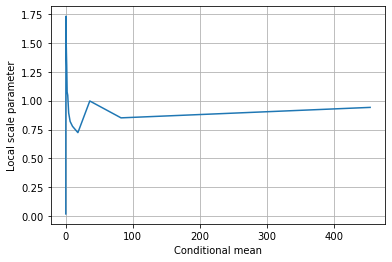

In [98]:
# # Merge in the total number of deaths by state
# td = dx.groupby("state").aggregate({"ddeath": np.sum})
# state_scale = pd.merge(state_scale, td, left_on="state", right_index=True)
# state_scale = state_scale.rename(columns={"ddeath": "total_deaths"})

## Assess the mean/variance relationship, attempt to find a
## relationship of the form Var(Y|X) = E[Y|X]^p

dr = pd.DataFrame({"fit": r1.fittedvalues, "resid": r1.resid_pearson})
dr["resid"] /= r1.fittedvalues**0.4 # Adjust this exponent to get a constant trend 
dr["fitg"] = pd.qcut(dr["fit"], 20)
p = r1.model.exog.shape[1]
print(p)
ds = dr.groupby("fitg").aggregate({"fitg": "first", "fit": np.mean,
                                   "resid": [np.var, lambda x: huber_scale(x, p/400)]})
ds.columns = [" ".join(x) for x in ds.columns]
ds = ds.rename(columns={"fitg first": "fit_range", "fit mean": "fit_mean",
                        "resid var": "scale", "resid <lambda_0>": "robust_scale"})

if use_termplot:
    fig = tpl.figure()
    fig.plot(ds.fit_mean, ds.robust_scale, xlabel="Conditional mean",
             title="Scale parameter")
    fig.show()

plt.clf()
plt.grid(True)
plt.plot(ds["fit_mean"].values.copy(), ds["robust_scale"].values.copy(), '-')
plt.xlabel("Conditional mean")
plt.ylabel("Local scale parameter")
pdf.savefig()


In [99]:
pa = r62.params
stfe = [[x[9:11], y] for x, y in zip(pa.index, pa.values) if "country" in x]
stfe = pd.DataFrame(stfe, columns=["country", "coef"])
stfe = stfe.sort_values(by="coef")
print("\nCountry fixed effects:\n")
# print(stfe, "\n\n")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(stfe)



Country fixed effects:

    country       coef
55       )[ -27.046716
12       )[ -26.386925
45       )[ -25.827216
107      )[ -25.280719
180      )[ -25.004669
117      )[ -24.734824
44       )[ -24.632946
100      )[ -24.491398
120      )[ -23.418252
150      )[ -10.506627
143      )[  -9.267530
110      )[  -8.450224
85       )[  -8.417957
18       )[  -8.155135
165      )[  -8.077718
101      )[  -7.932969
169      )[  -7.798213
0        )[  -7.710677
96       )[  -7.688643
62       )[  -7.677651
5        )[  -7.664194
104      )[  -7.644217
114      )[  -7.458427
28       )[  -7.431592
67       )[  -7.427758
46       )[  -7.423685
49       )[  -7.273719
21       )[  -7.269102
146      )[  -7.231283
124      )[  -7.194715
181      )[  -7.147458
34       )[  -7.111877
41       )[  -7.101924
132      )[  -7.089088
66       )[  -7.062672
159      )[  -7.062254
137      )[  -6.957304
130      )[  -6.946351
157      )[  -6.942340
29       )[  -6.918619
142      )[  -6.911976
22       

In [100]:
pdf.close()